In [8]:
import re
import pandas as pd
from pathlib import Path
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt

In [11]:
file_map = {
    "lggfn": "lggfn_comparison_table.txt",
    "tb": "tb_comparison_table.txt",
    # "sagfn": "small_prot2/sagfn_comparison_table.txt"
}

def parse_comparison_file(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()

    data_lines = [line.strip() for line in lines if line.strip().startswith("|")]
    parsed_data = [line.strip("|").split("|") for line in data_lines]
    parsed_data = [[item.strip() for item in row] for row in parsed_data]

    columns = parsed_data[0]
    rows = parsed_data[1:]

    df = pd.DataFrame(rows, columns=columns)

    for col in ['GC %', 'MFE', 'CAI', 'Levenshtein', 'Identity %']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

dfs = {name: parse_comparison_file(path) for name, path in file_map.items()}

df_lggfn = dfs["lggfn"]
df_tb = dfs["tb"]
# df_sagfn = dfs["sagfn"]

In [12]:
df_tb['Model'] = 'TB GFlowNet'
# df_sagfn['Model'] = 'Sibling Adapted GFN'
df_lggfn['Model'] = 'Loss Guided GFN'

#df_combined = pd.concat([df_tb,df_sagfn, df_lggfn], ignore_index=True)

df_combined = pd.concat([df_tb, df_lggfn], ignore_index=True)

natural_seq = pd.DataFrame([{'MFE': -152.3, 'CAI': 0.47, 'Model': 'Natural'}])

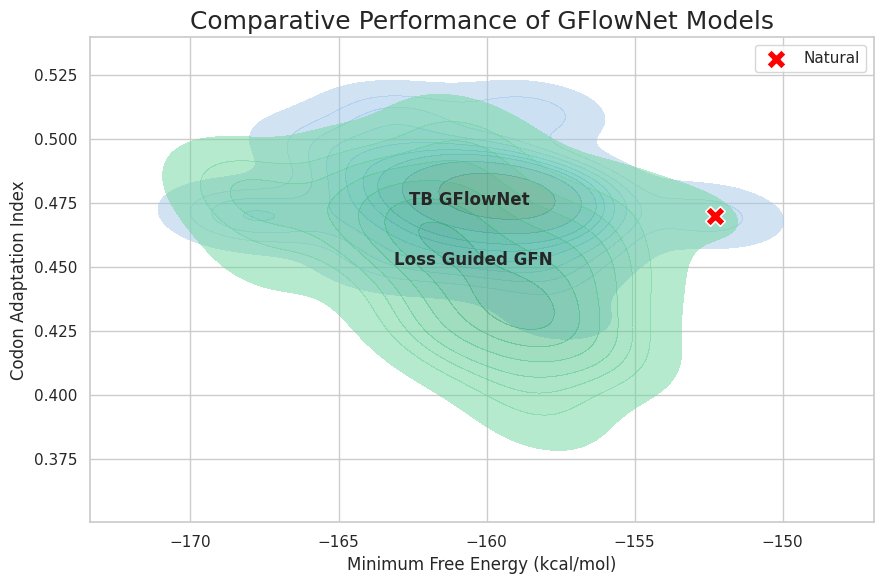

In [13]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

sns.kdeplot(data=df_combined, x='MFE', y='CAI', hue='Model',
            fill=True, alpha=0.5, palette='viridis', legend=False)

sns.scatterplot(data=natural_seq, x='MFE', y='CAI',
                marker='X', s=200, color='red', label='Natural', zorder=5)


model_centers = df_combined.groupby('Model')[['MFE', 'CAI']].mean()

for model_name, center in model_centers.iterrows():
    plt.text(x=center['MFE'], y=center['CAI'], s=model_name,
             fontsize=12,
             fontweight='bold',
             ha='center',
             va='center') 

plt.title('Comparative Performance of GFlowNet Models', fontsize=18)
plt.xlabel('Minimum Free Energy (kcal/mol)', fontsize=12)
plt.ylabel('Codon Adaptation Index', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

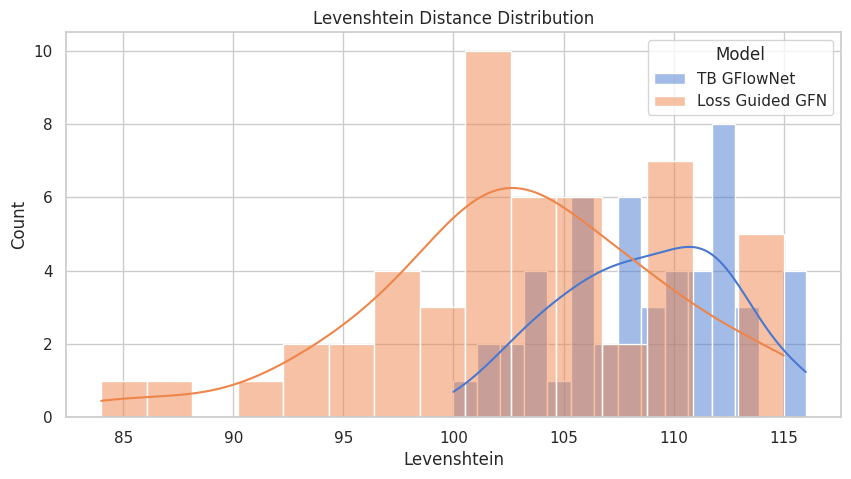

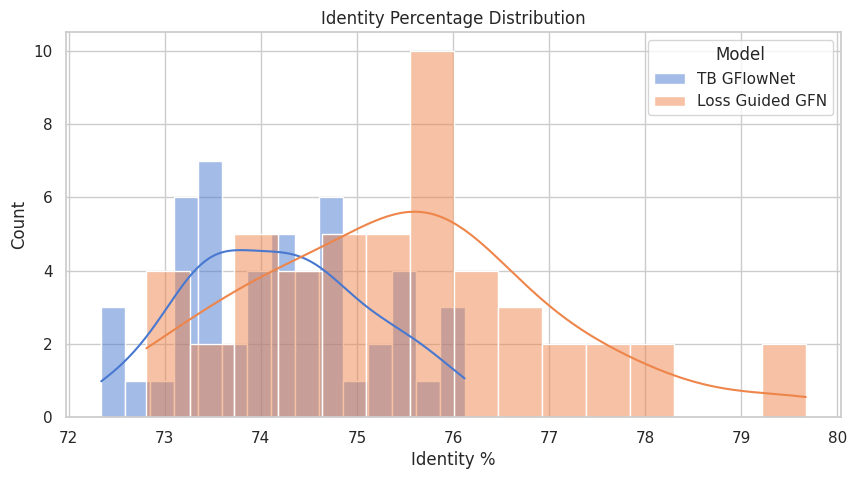

In [14]:
sns.set(style="whitegrid", palette="muted")

# Levenshtein Distance
plt.figure(figsize=(10, 5))
sns.histplot(df_tb[df_tb["Seq"].str.contains("Gen")]['Levenshtein'], kde=True, bins=15,  label='TB GFlowNet')
sns.histplot(df_lggfn[df_lggfn["Seq"].str.contains("Gen")]['Levenshtein'], kde=True, bins=15, label='Loss Guided GFN')
#sns.histplot(df_sagfn[df_sagfn["Seq"].str.contains("Gen")]['Levenshtein'], kde=True, bins=15, label='Sibling Adapted GFN')
plt.title("Levenshtein Distance Distribution")
plt.legend(title="Model")
plt.show()

# Identity %
plt.figure(figsize=(10, 5))
sns.histplot(df_tb[df_tb["Seq"].str.contains("Gen")]['Identity %'], kde=True, bins=15,  label='TB GFlowNet')
sns.histplot(df_lggfn[df_lggfn["Seq"].str.contains("Gen")]['Identity %'], kde=True, bins=15, label='Loss Guided GFN')
#sns.histplot(df_sagfn[df_sagfn["Seq"].str.contains("Gen")]['Identity %'], kde=True, bins=15, label='Sibling Adapted GFN')
plt.title("Identity Percentage Distribution")
plt.legend(title="Model")
plt.show()

In [2]:
records = []
pattern = re.compile(r"Sequence\s*(\d+):\s*([AUCG]+),\s*Reward:\s*([\d\.]+)")
for txt in Path("/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/long_prot").glob("generated_sequences_for_algo_*.txt"):
    model = txt.stem.split("_")[-1]
    for line in open(txt):
        m = pattern.search(line)
        if m:
            seq_id = int(m.group(1))
            seq, reward = m.group(2), float(m.group(3))
            records.append({"model": model, "seq_id": seq_id,
                            "sequence": seq, "reward": reward})
df_seq = pd.DataFrame(records)

In [3]:
df_seq

,model,seq_id,sequence,reward
0,tb,1,AUGACAUCCAUGACACAAUCAUUACGGGAAGUGAUAAAAGCCAUGA...,64.39
1,tb,2,AUGACCUCUAUGACUCAAUCCCUGAGGGAGGUUAUAAAAGCCAUGA...,64.05
2,tb,3,AUGACCAGCAUGACGCAAUCUCUGCGGGAGGUUAUCAAGGCUAUGA...,63.90
3,tb,4,AUGACUAGCAUGACGCAAAGCUUGCGCGAGGUUAUCAAAGCUAUGA...,63.80
4,tb,5,AUGACAAGUAUGACUCAGAGUUUACGGGAGGUGAUAAAGGCAAUGA...,63.33
...,...,...,...,...
95,lggfn,46,AUGACGUCUAUGACCCAAAGCCUCAGGGAAGUUAUUAAGGCAAUGA...,60.85
96,lggfn,47,AUGACCAGCAUGACGCAGUCUUUGCGCGAGGUCAUCAAGGCCAUGA...,60.81
97,lggfn,48,AUGACGUCGAUGACACAGUCACUACGUGAAGUUAUAAAAGCUAUGA...,60.80
98,lggfn,49,AUGACAUCUAUGACUCAAUCUUUACGUGAAGUUAUAAAGGCUAUGA...,60.73


In [4]:
data_dir = Path("/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/long_prot")

line_re = re.compile(
    r"Sequence\s*\d+:\s*([AUCG]+),\s*Reward:\s*([\d\.]+)"
)

records = []

for txt in data_dir.glob("generated_sequences_for_algo_*.txt"):
    model = txt.stem.split("_")[-1]
    with open(txt) as f:
        for line in f:
            m = line_re.search(line)
            if m:
                seq, reward = m.group(1), float(m.group(2))
                records.append({"model": model, "sequence": seq, "reward": reward})


df = pd.DataFrame(records)

print(df.groupby("model")["reward"].agg(["count","mean"]))
print(df.head())

       count     mean
model                
lggfn     50  62.0762
tb        50  62.1690
  model                                           sequence  reward
0    tb  AUGACAUCCAUGACACAAUCAUUACGGGAAGUGAUAAAAGCCAUGA...   64.39
1    tb  AUGACCUCUAUGACUCAAUCCCUGAGGGAGGUUAUAAAAGCCAUGA...   64.05
2    tb  AUGACCAGCAUGACGCAAUCUCUGCGGGAGGUUAUCAAGGCUAUGA...   63.90
3    tb  AUGACUAGCAUGACGCAAAGCUUGCGCGAGGUUAUCAAAGCUAUGA...   63.80
4    tb  AUGACAAGUAUGACUCAGAGUUUACGGGAGGUGAUAAAGGCAAUGA...   63.33


In [5]:
files = {
    # "sagfn": "/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/small_prot2/sagfn_comparison_table.txt",
    "lggfn": "/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/long_prot/lggfn_comparison_table.txt",
    "tb": "/home/ubuntu/aya/Loss-Guided-GFN/src/envs/Bio_env/long_prot/tb_comparison_table.txt"
}

In [6]:
def parse_table(file_path, model_name):
    with open(file_path, "r") as f:
        lines = f.readlines()

    data_lines = [line for line in lines if re.match(r"\|\s*\w+", line)]
    header_line = data_lines[0]
    columns = [col.strip() for col in header_line.strip("| \n").split("|")]

    data = []
    for line in data_lines[1:]:  # Skip header
        row = [cell.strip() for cell in line.strip("| \n").split("|")]
        row.append(model_name)  # Add model column
        data.append(row)

    columns.append("model")
    df = pd.DataFrame(data, columns=columns)

    numeric_cols = ["GC %", "MFE", "CAI", "Levenshtein", "Identity %"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

dfs = [parse_table(path, model) for model, path in files.items()]
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.head())

     Seq   GC %     MFE   CAI  Levenshtein  Identity %  model
0  Gen 1  47.99 -168.00  0.48          115       72.81  lggfn
1  Gen 2  46.34 -167.97  0.47           92       78.25  lggfn
2  Gen 3  45.86 -167.60  0.45          104       75.41  lggfn
3  Gen 4  47.52 -164.70  0.48          106       74.70  lggfn
4  Gen 5  47.52 -163.33  0.47          101       75.89  lggfn


/tmp/ipykernel_613676/1882417105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="model", y="reward", data=df_seq, palette=palette, width=0.6, fliersize=3)
/tmp/ipykernel_613676/1882417105.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(x="model", y="reward", data=df_seq, palette=palette, width=0.6, fliersize=3)


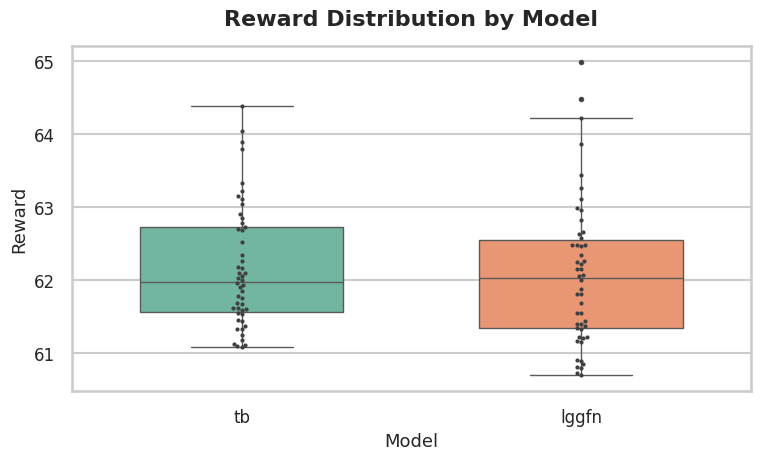

In [9]:
sns.set(style="whitegrid", context="talk", font_scale=1.1)

palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 5))
ax = sns.boxplot(x="model", y="reward", data=df_seq, palette=palette, width=0.6, fliersize=3)

sns.swarmplot(x="model", y="reward", data=df_seq, color=".25", size=3, ax=ax)

ax.set_title("Reward Distribution by Model", fontsize=16, weight='bold', pad=15)
ax.set_xlabel("Model", fontsize=13)
ax.set_ylabel("Reward", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Average reward of top 20 sequences per model:
 model
lggfn    63.040
tb       63.011
Name: reward, dtype: float64


/tmp/ipykernel_613676/582832454.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="model", y="reward", data=top20_df, palette=palette, width=0.6, fliersize=3)
/tmp/ipykernel_613676/582832454.py:15: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(x="model", y="reward", data=top20_df, palette=palette, width=0.6, fliersize=3)


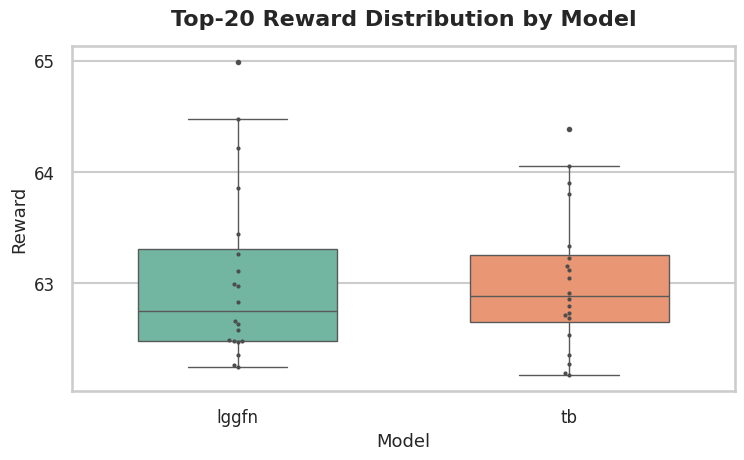

In [10]:
top20_df = (
    df_seq.sort_values(by=["model", "reward"], ascending=[True, False])
          .groupby("model", group_keys=False)
          .head(20)
)


avg_rewards = top20_df.groupby("model")["reward"].mean()
print("Average reward of top 20 sequences per model:\n", avg_rewards)

sns.set(style="whitegrid", context="talk", font_scale=1.1)
palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 5))
ax = sns.boxplot(x="model", y="reward", data=top20_df, palette=palette, width=0.6, fliersize=3)
sns.swarmplot(x="model", y="reward", data=top20_df, color=".3", size=3, ax=ax)

ax.set_title("Top-20 Reward Distribution by Model", fontsize=16, weight='bold', pad=15)
ax.set_xlabel("Model", fontsize=13)
ax.set_ylabel("Reward", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()